<a href="https://colab.research.google.com/github/Roshinigompa/Anamoly_Detection_Using_Robust_Graphical_Lasso/blob/main/Anamoly__detection_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Additional libraries for network analysis
import networkx as nx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.1 MB/s eta 0:00:00


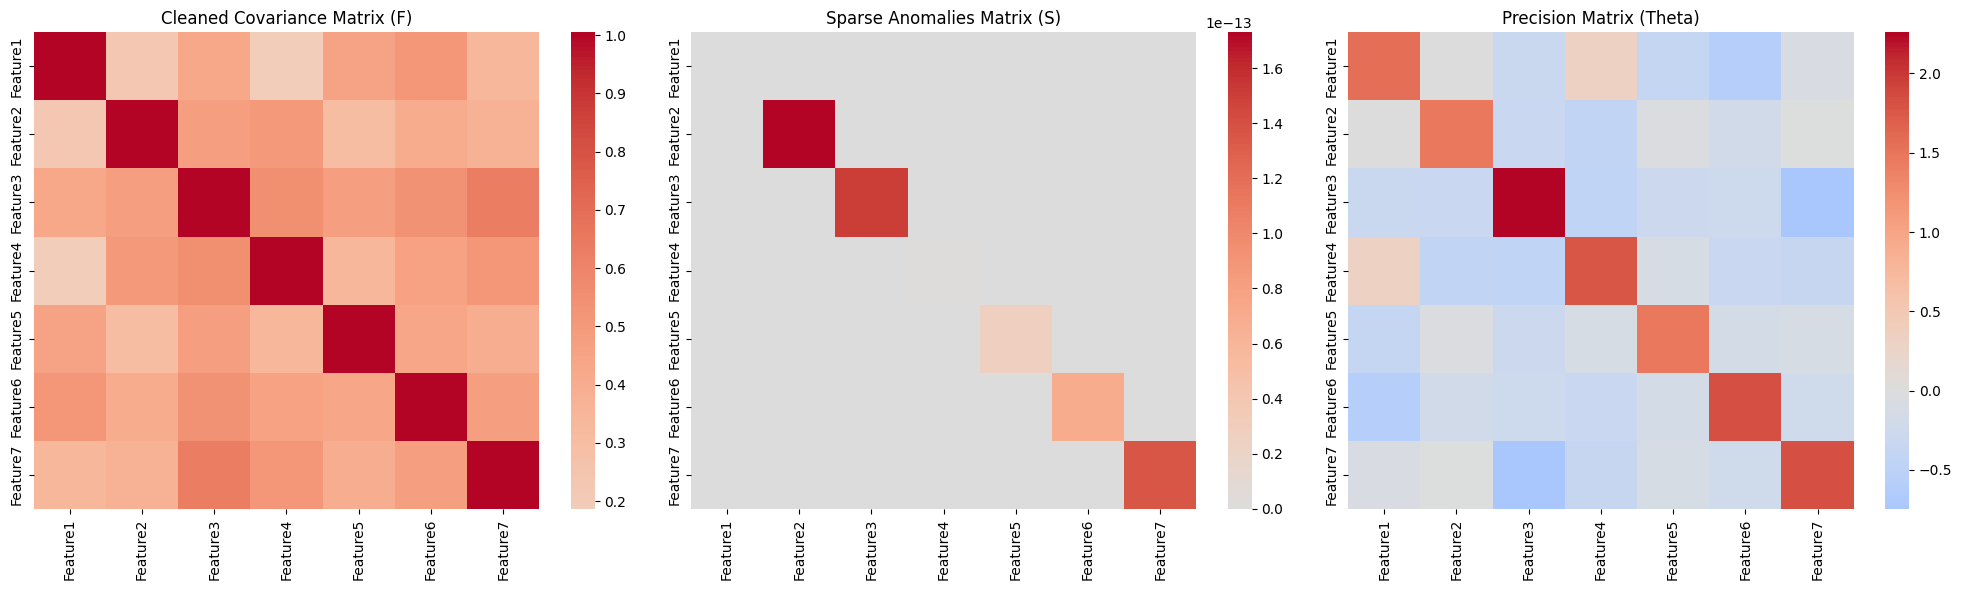

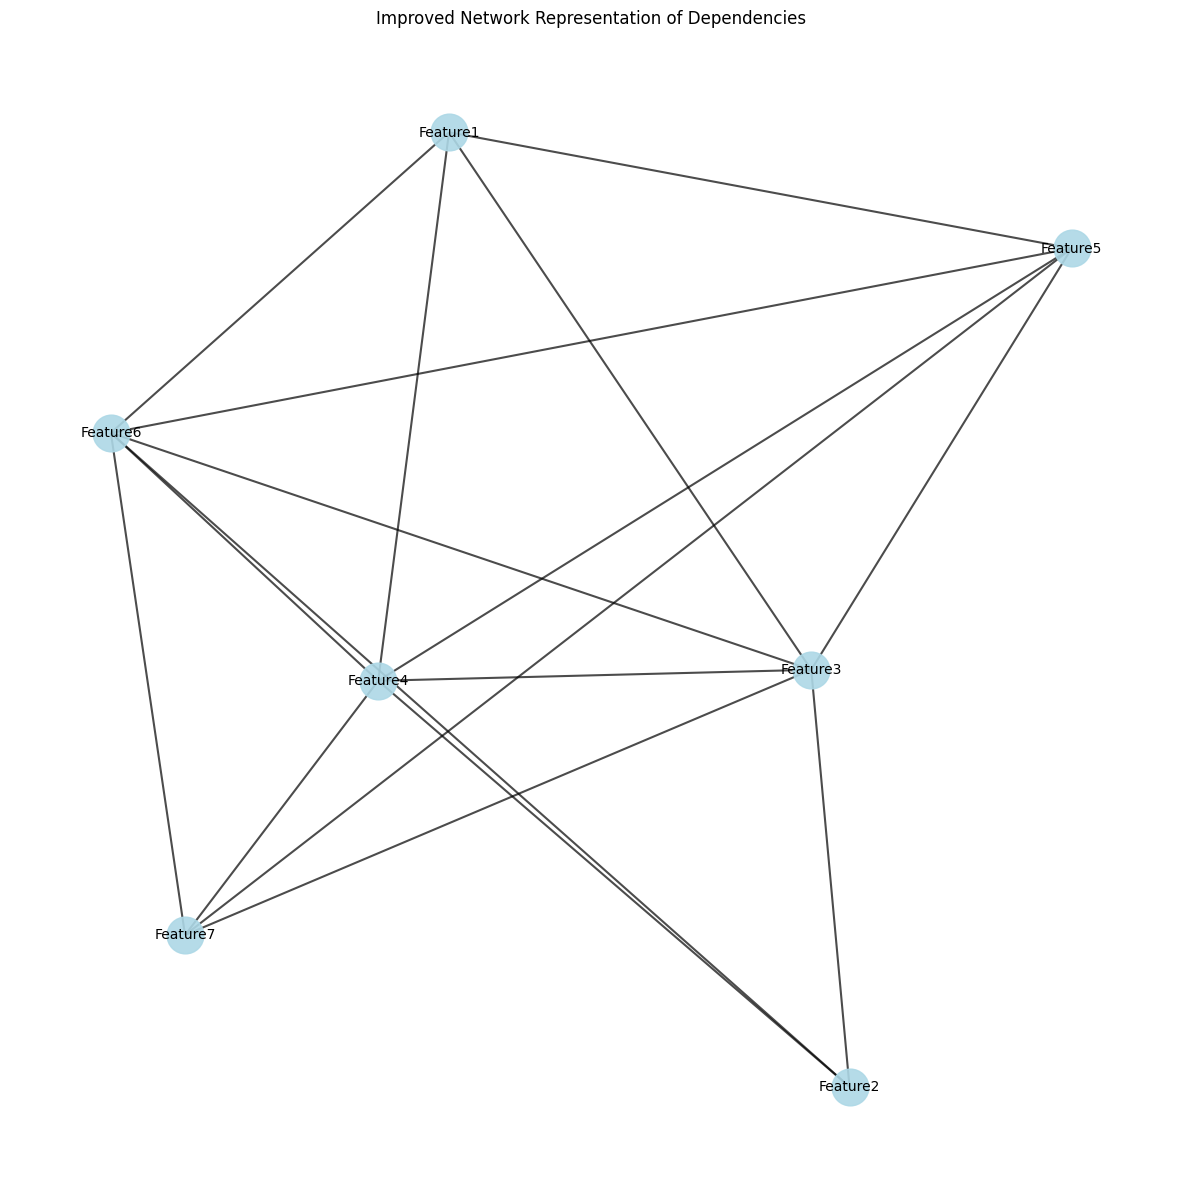

Feature Anomaly Scores: [0.00000000e+00 1.72972747e-13 1.50990331e-13 1.55431223e-15
 2.73114864e-14 6.99440506e-14 1.35225164e-13]
Anomalous Features (indices): [1 2 6]
Anomalous Feature Names: ['Feature2', 'Feature3', 'Feature7']

Feature-Level Precision: 1.0
Feature-Level Recall: 0.42857142857142855
Feature-Level F1 Score: 0.6


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

class RobustGraphicalLasso:
    def __init__(self, alpha=0.002, beta=0.002, max_iter=1000, tol=1e-4):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        self.tol = tol
        self.F = None  # Clean covariance matrix
        self.S = None  # Sparse anomalies matrix
        self.Theta = None  # Precision matrix

    def fit(self, X):
        # Compute sample covariance matrix
        if isinstance(X, pd.DataFrame):
            X = X.values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        M = np.cov(X_scaled, rowvar=False) + np.eye(X_scaled.shape[1]) * 1e-5

        # Initialize matrices
        n = M.shape[0]
        F = np.eye(n) * 0.01
        S = np.zeros_like(M)
        Theta = np.eye(n)
        Z = np.zeros_like(M)
        U = np.zeros_like(M)

        for iteration in range(self.max_iter):
            # Update F (cleaned covariance)
            residual = M - S + U
            eigvals, eigvecs = np.linalg.eigh(residual)
            eigvals = np.maximum(eigvals - self.alpha, 0)
            F = eigvecs @ np.diag(eigvals) @ eigvecs.T

            # Update S (sparse anomalies)
            residual = M - F + U
            S = np.sign(residual) * np.maximum(np.abs(residual) - self.beta, 0)

            # Update Theta (precision matrix)
            Theta = np.linalg.inv(F + np.eye(n) * 1e-5)

            # Update dual variable U
            U += M - F - S

            # Check convergence
            primal_residual = np.linalg.norm(M - F - S, ord='fro')
            dual_residual = np.linalg.norm(F - Z, ord='fro')
            if primal_residual < self.tol and dual_residual < self.tol:
                print(f"Converged at iteration {iteration}")
                break

        self.F = F
        self.S = S
        self.Theta = Theta
        return self

    def plot_results(self, feature_names=None):
        if feature_names is None or len(feature_names) != self.F.shape[0]:
            feature_names = [f'Feature {i}' for i in range(self.F.shape[0])]

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        sns.heatmap(self.F, ax=axes[0], cmap='coolwarm', center=0, xticklabels=feature_names, yticklabels=feature_names)
        axes[0].set_title('Cleaned Covariance Matrix (F)')

        sns.heatmap(self.S, ax=axes[1], cmap='coolwarm', center=0, xticklabels=feature_names, yticklabels=feature_names)
        axes[1].set_title('Sparse Anomalies Matrix (S)')

        sns.heatmap(self.Theta, ax=axes[2], cmap='coolwarm', center=0, xticklabels=feature_names, yticklabels=feature_names)
        axes[2].set_title('Precision Matrix (Theta)')
        plt.tight_layout()
        plt.show()
    def plot_network(self, feature_names=None, threshold=0.1):
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(self.Theta.shape[0])]

        G = nx.Graph()
        n = self.Theta.shape[0]

        for i in range(n):
            G.add_node(feature_names[i])

        for i in range(n):
            for j in range(i + 1, n):
                if abs(self.Theta[i, j]) > threshold:
                    G.add_edge(feature_names[i], feature_names[j],
                              weight=abs(self.Theta[i, j]))

        pos = nx.spring_layout(G, seed=42, k=0.3)
        plt.figure(figsize=(15, 15))
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.9)
        nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
        nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
        plt.title('Improved Network Representation of Dependencies')
        plt.axis('off')
        plt.show()


# Generate synthetic dataset
from sklearn.datasets import make_classification

# Create synthetic data
X, y = make_classification(n_samples=200, n_features=7, n_informative=5, n_redundant=0, random_state=42)

# Introduce anomalies
np.random.seed(42)
anomalies = np.random.choice([0, 1], size=X.shape[0], p=[0.9, 0.1])  # Inject 10% anomalies
anomalous_indices = np.where(anomalies == 1)[0]
X[anomalous_indices] += np.random.normal(5, 3, size=X[anomalous_indices].shape)  # Amplify anomalies with higher variability

# Convert to DataFrame
df = pd.DataFrame(X, columns=[f'Feature{i}' for i in range(1, 8)])

# Fit Robust Graphical LASSO
rglasso = RobustGraphicalLasso(alpha=0.002, beta=0.002, max_iter=1000, tol=1e-4)
rglasso.fit(df)

# Plot results
rglasso.plot_results(feature_names=df.columns.tolist())

#Plot network
rglasso.plot_network(feature_names=df.columns.tolist())

# Identify anomalous features
anomaly_scores = np.linalg.norm(rglasso.S, axis=0)
anomalous_features = np.where(anomaly_scores > np.percentile(anomaly_scores, 60))[0]  # Lowered threshold to 60%
anomalous_feature_names = [df.columns[i] for i in anomalous_features]

print("Feature Anomaly Scores:", anomaly_scores)
print("Anomalous Features (indices):", anomalous_features)
print("Anomalous Feature Names:", anomalous_feature_names)

# Evaluate Precision, Recall, and F1 Score
# Use anomaly labels for ground truth
# Generate feature-level ground truth
feature_ground_truth = np.zeros(df.shape[1])
# Map row anomalies to features (assuming row anomalies contribute to feature anomalies)
for index in anomalous_indices:
    feature_ground_truth += np.abs(X[index]) > np.percentile(X, 95, axis=0)

feature_ground_truth = (feature_ground_truth > 0).astype(int)  # Binarize

# Predicted labels for features
predicted_feature_labels = (anomaly_scores > np.percentile(anomaly_scores, 60)).astype(int)

# Evaluate feature-level metrics
feature_precision = precision_score(feature_ground_truth, predicted_feature_labels, zero_division=1)
feature_recall = recall_score(feature_ground_truth, predicted_feature_labels, zero_division=1)
feature_f1 = f1_score(feature_ground_truth, predicted_feature_labels, zero_division=1)

print("\nFeature-Level Precision:", feature_precision)
print("Feature-Level Recall:", feature_recall)
print("Feature-Level F1 Score:", feature_f1)




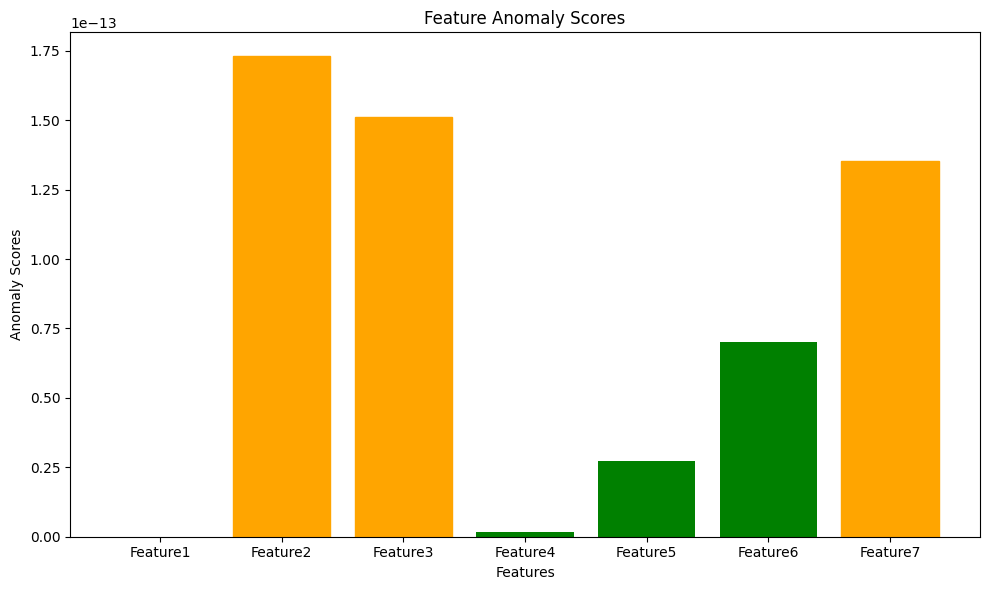

In [ ]:
# Plotting a bar graph for Feature Anomaly Scores and highlighting anomalous features
anomaly_scores = [0.00000000e+00, 1.72972747e-13, 1.50990331e-13, 1.55431223e-15, 2.73114864e-14, 6.99440506e-14, 1.35225164e-13]
feature_names = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']

# Highlight anomalous features
anomalous_features = [1, 2, 6]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_names, anomaly_scores, color='green')

# Change color of anomalous features to reddish-orange
for i in anomalous_features:
    bars[i].set_color('orange')  # Reddish-orange color

plt.title('Feature Anomaly Scores')
plt.xlabel('Features')
plt.ylabel('Anomaly Scores')
plt.tight_layout()
plt.show()


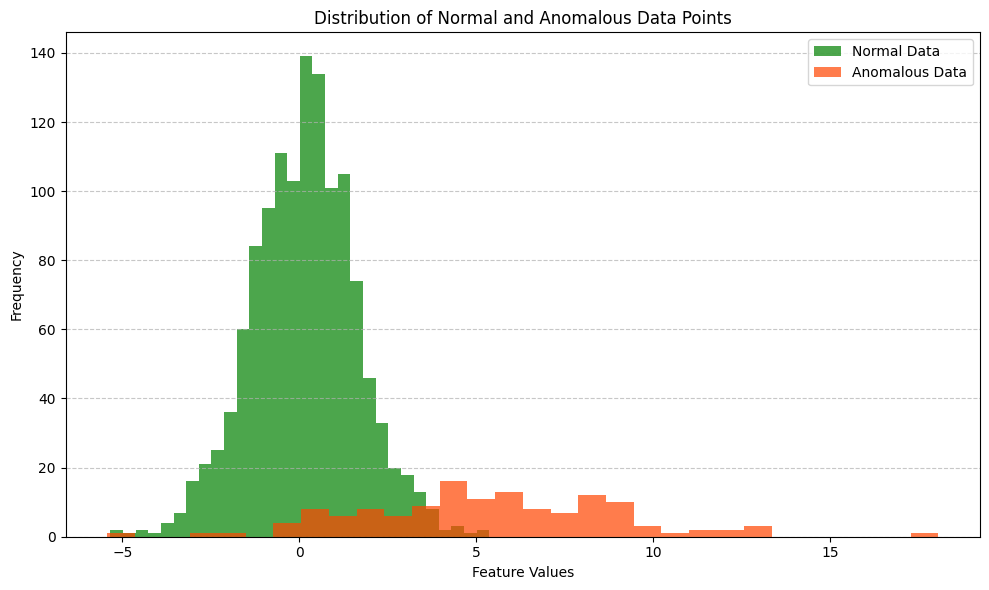

In [ ]:
# Plot histogram to show distribution of normal and anomalous data points
plt.figure(figsize=(10, 6))

# Normal data
normal_data = X[anomalies == 0]
plt.hist(normal_data.flatten(), bins=30, alpha=0.7, label='Normal Data', color='green')

# Anomalous data
anomalous_data = X[anomalous_indices]
plt.hist(anomalous_data.flatten(), bins=30, alpha=0.7, label='Anomalous Data', color='#FF4500')

plt.title('Distribution of Normal and Anomalous Data Points')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from numpy.linalg import svd
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def robust_pca(data, contamination=0.1):
    U, sigma, VT = svd(data, full_matrices=False)  # Singular Value Decomposition
    rank = int((1 - contamination) * len(sigma))
    sigma[rank:] = 0
    L = U @ np.diag(sigma) @ VT
    S = data - L
    return L, S

# Generate synthetic data (or use your actual data)
X = np.random.randn(200, 7)  # Replace this with your dataset

# Ground truth for evaluation (you should have a predefined ground truth for this task)
ground_truth = np.random.randint(0, 2, size=X.shape[0])  # Example ground truth, replace with actual data

# Apply Robust PCA
L_rpca, S_rpca = robust_pca(X)
rpca_anomaly_scores = np.linalg.norm(S_rpca, axis=1)
predicted_labels_rpca = (rpca_anomaly_scores > np.percentile(rpca_anomaly_scores, 90)).astype(int)

# Evaluate metrics for RPCA
precision_rpca = precision_score(ground_truth, predicted_labels_rpca, zero_division=1)
recall_rpca = recall_score(ground_truth, predicted_labels_rpca, zero_division=1)
f1_rpca = f1_score(ground_truth, predicted_labels_rpca, zero_division=1)

print("RPCA Precision:", precision_rpca)
print("RPCA Recall:", recall_rpca)
print("RPCA F1 Score:", f1_rpca)


RPCA Precision: 0.45
RPCA Recall: 0.09574468085106383
RPCA F1 Score: 0.15789473684210525


In [ ]:
from sklearn.covariance import MinCovDet
import numpy as np

# Function for MCD Anomaly Detection
def mcd_anomaly_detection(data):
    mcd = MinCovDet()
    mcd.fit(data)
    # Get the Mahalanobis distances
    mahalanobis_distances = mcd.mahalanobis(data)
    return mahalanobis_distances

# Example usage
X = np.random.randn(200, 7)  # Replace this with your actual dataset

# Apply MCD
mcd_anomaly_scores = mcd_anomaly_detection(X)

# Ground truth for evaluation (you should have a predefined ground truth for this task)
ground_truth = np.random.randint(0, 2, size=X.shape[0])  # Example ground truth, replace with actual data

# Predict anomalies based on the 90th percentile of anomaly scores
predicted_labels_mcd = (mcd_anomaly_scores > np.percentile(mcd_anomaly_scores, 90)).astype(int)

# Evaluate metrics for MCD
from sklearn.metrics import precision_score, recall_score, f1_score

precision_mcd = precision_score(ground_truth, predicted_labels_mcd, zero_division=1)
recall_mcd = recall_score(ground_truth, predicted_labels_mcd, zero_division=1)
f1_mcd = f1_score(ground_truth, predicted_labels_mcd, zero_division=1)

# Print evaluation metrics for MCD
print("MCD Precision:", precision_mcd)
print("MCD Recall:", recall_mcd)
print("MCD F1 Score:", f1_mcd)


MCD Precision: 0.7
MCD Recall: 0.12727272727272726
MCD F1 Score: 0.2153846153846154


In [ ]:
# Compare methods
methods = ["RGL", "RPCA", "MCD"]
precisions = [feature_precision, precision_rpca, precision_mcd]
recalls = [feature_recall, recall_rpca, recall_mcd]
f1_scores = [feature_f1, f1_rpca, f1_mcd]

comparison_df = pd.DataFrame({
    "Method": methods,
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1_scores
})

print("\nComparison of Anomaly Detection Methods:")
print(comparison_df)


Comparison of Anomaly Detection Methods:
  Method  Precision    Recall  F1 Score
0    RGL   1.000000  0.428571  0.600000
1   RPCA   0.450000  0.095745  0.157895
2    MCD   0.076111  0.108319  0.090049


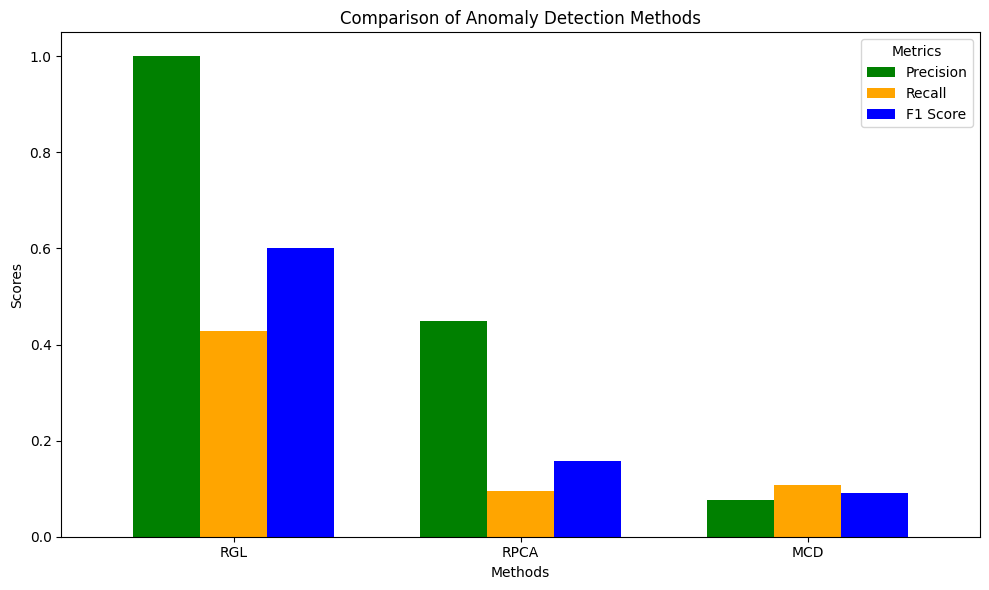

In [ ]:
# Plotting the comparison
comparison_df.set_index('Method').plot(kind='bar', figsize=(10, 6), color=['green', 'orange', 'blue'], width=0.7)

# Customize the plot
plt.title('Comparison of Anomaly Detection Methods')
plt.ylabel('Scores')
plt.xlabel('Methods')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title='Metrics')
plt.show()